# Assumptions 
*The difference between paired measurements (daily step counts) follows a normal distribution*

In [23]:
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from datetime import datetime

In [33]:
ao = pd.read_csv("alex_steps_per_day.csv")
lg = pd.read_csv("lindsay_steps_per_day.csv")

df = pd.merge(ao, lg, on="date")
df['diffs'] = df['steps_x'] - df['steps_y']
df['date'] = df['date'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d"))
df = df[df['date'] >= datetime(2024,1,1)]
df = df[df['date'] >= datetime(2025,1,15)]

df

,date,steps_x,steps_y,diffs
393,2025-01-15,4987,6741,-1754
394,2025-01-16,11230,3859,7371
395,2025-01-17,5426,6996,-1570
396,2025-01-18,11569,9062,2507
397,2025-01-19,13612,4004,9608
...,...,...,...,...
672,2025-10-27,8351,13618,-5267
673,2025-10-28,8992,7327,1665
674,2025-10-29,8893,1392,7501
675,2025-10-30,6461,1703,4758


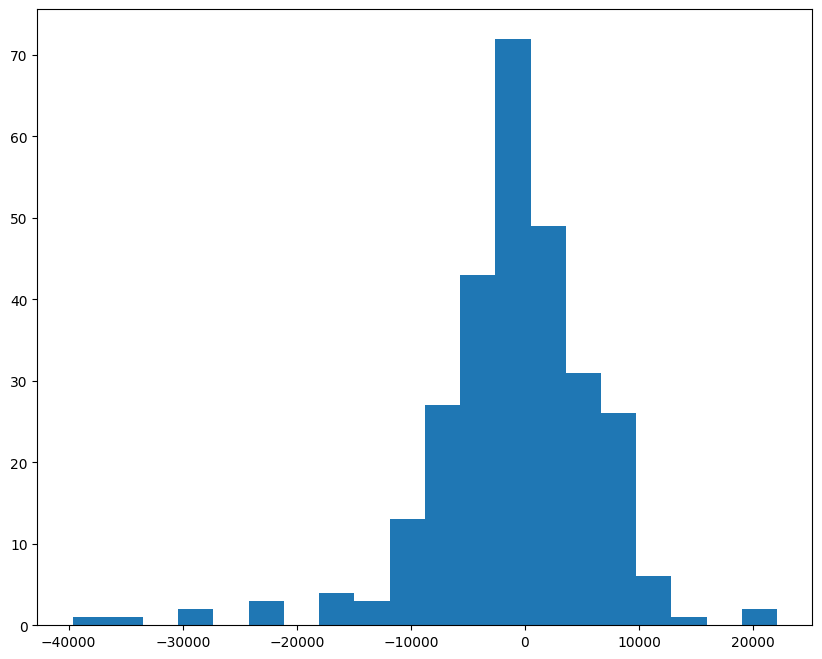

In [35]:
plt.figure(figsize=(10,8))
plt.hist(df['diffs'], bins =20)
plt.show()

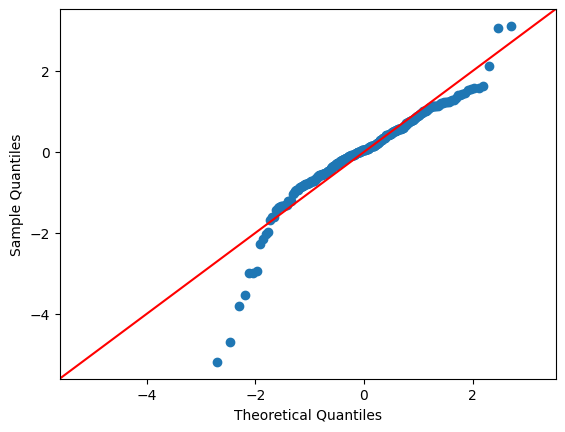

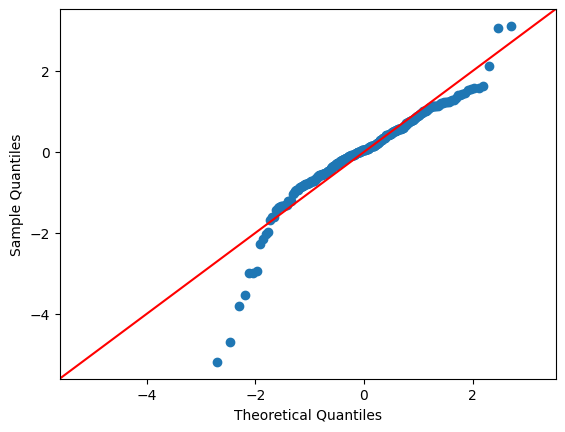

In [36]:
sm.qqplot(df['diffs'], line="45",fit =True)


The histogram seems to b